In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tensorboardX
from tensorboardX import SummaryWriter
import os

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import fiona
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json
import secrets

In [23]:
def parse_polygon(coordinates: dict, image_size: tuple) -> np.ndarray:
    mask = np.zeros(image_size, dtype=np.float32)
    if len(coordinates) == 1:
        points = [np.int32(coordinates)]
        cv2.fillPoly(mask, points, 1)
    else:
        points = [np.int32(coordinates[0])]
        cv2.fillPoly(mask, points, 1)
        for polygon in coordinates[1:]:
            points = [np.int32([polygon])]
            cv2.fillPoly(mask, points, 0)
    return mask


def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:

    mask = np.zeros(image_size, dtype=np.float32)
    coordinates = shape['coordinates']
    if shape['type'] == 'MultiPolygon':
        for polygon in coordinates:
            mask += parse_polygon(polygon, image_size)
    else:
        mask += parse_polygon(coordinates, image_size)
    
    return mask

def read_layout( path: str, image_size: tuple) -> np.ndarray:

    with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
        json_contents = json.load(f)
            
    num_channels = 2
        
    mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
    mask = np.zeros(image_size, dtype=np.float32)

    if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
        features = json_contents['features']
    elif type(json_contents) == list:
        features = json_contents
    else:
        features = [json_contents]

    for shape in features:
        channel_id = 1 #lass_ids["vessel"]
        mask = parse_mask(shape['geometry'], image_size)
        mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

    mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

    return np.stack(mask_channels, axis=-1)


json_path = '../train_dataset_mc/jsons'
files = os.listdir(json_path)
for f in files:
    name = f.strip().split(".")[0] + ".npy"
    mask = read_layout(os.path.join(json_path, f), (1232, 1624))
    out = mask[:,:,1]
    np.save(os.path.join("../train_dataset_mc/new_masks", name), out)
    #out = mask[:,:,1]
    print(set(out.reshape(-1)))
    print(out.shape)
    #plt.imshow(mask[:,:,1])
    #plt.show()

{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0, 2.0}
(1232, 1624)
{0.0, 1.0}
(1232, 1624)
{0.0, 1.0

In [25]:
a = os.listdir('../train_dataset_mc/new_masks')
b = os.listdir('../train_dataset_mc/masks')
print(set(a) - set(b))

{'523 .npy', '206.npy'}


In [ ]:
train_dataset_path = "../train_dataset_mc"

In [ ]:
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

In [58]:
images = "../train_dataset_mc/images/"

In [41]:
import matplotlib.pyplot as plt

In [42]:
mask = np.load("../train_dataset_mc/masks/11.npy")

In [43]:
masks = glob.glob("../train_dataset_mc/masks/*.npy")

../train_dataset_mc/masks/492.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


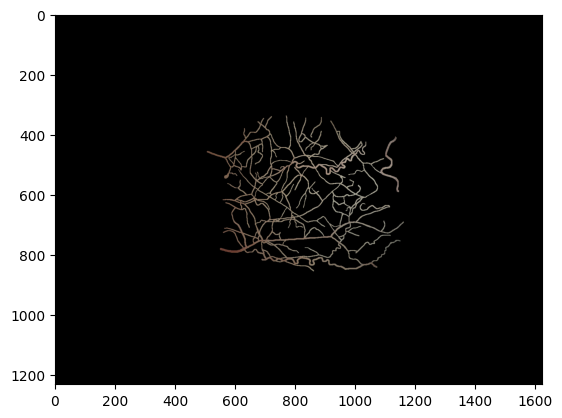

../train_dataset_mc/masks/298.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


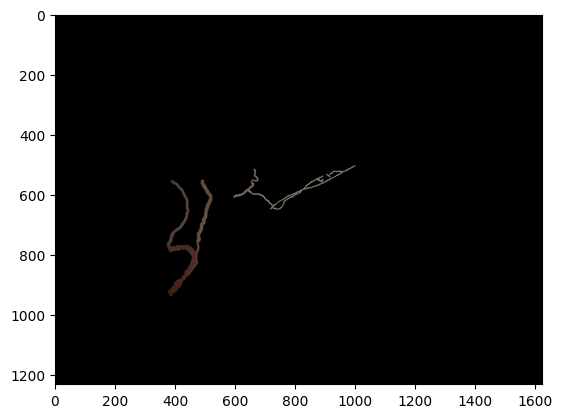

../train_dataset_mc/masks/744.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


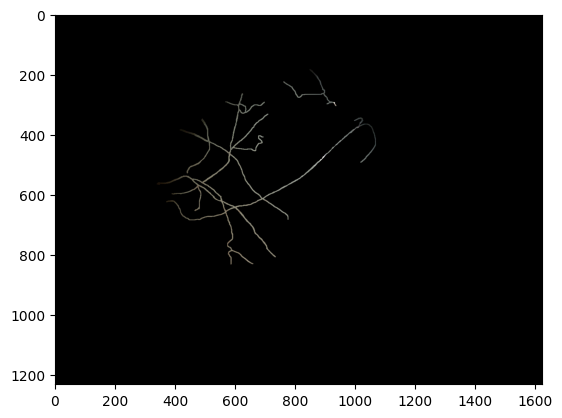

../train_dataset_mc/masks/444.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


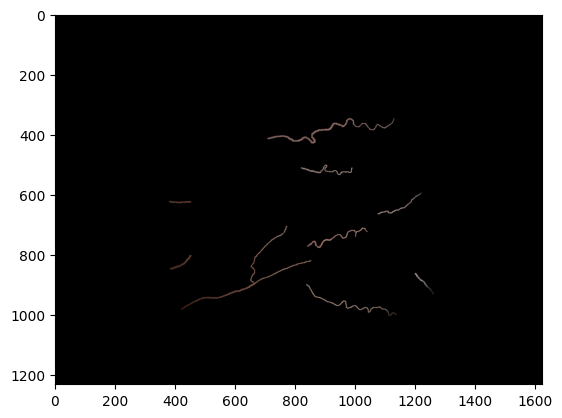

../train_dataset_mc/masks/158.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


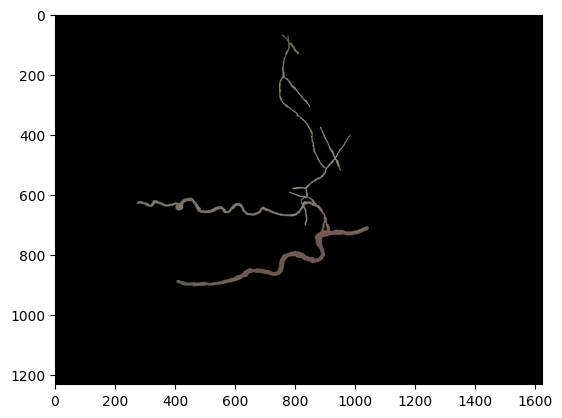

../train_dataset_mc/masks/70.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


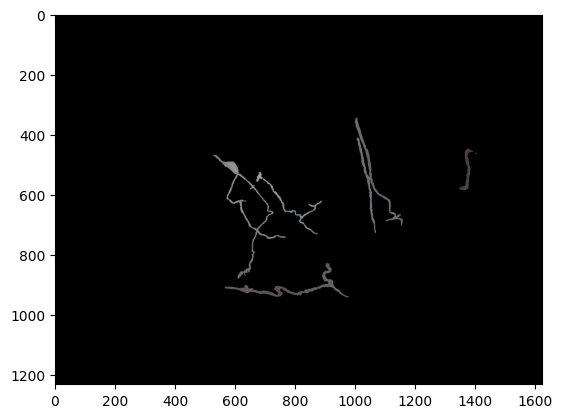

../train_dataset_mc/masks/477.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


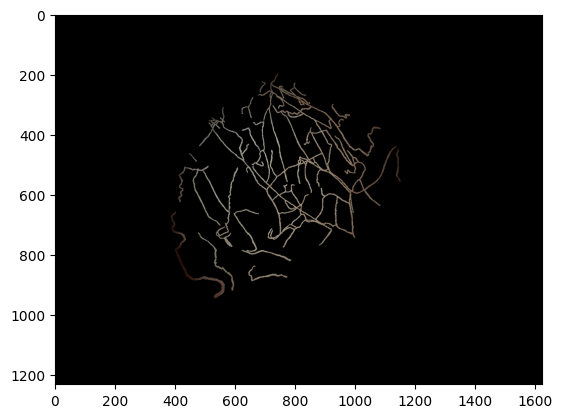

../train_dataset_mc/masks/392.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


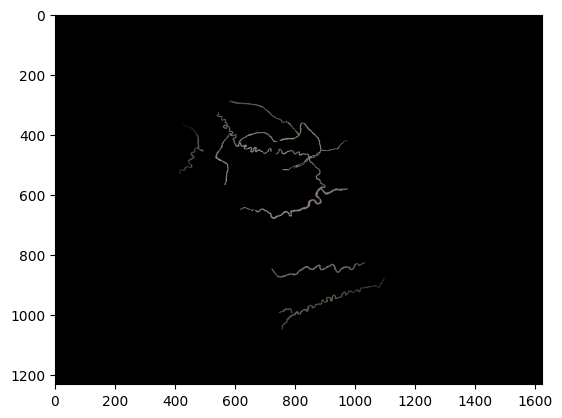

../train_dataset_mc/masks/501.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


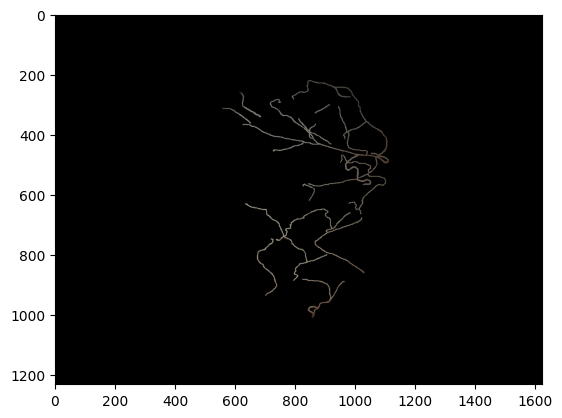

../train_dataset_mc/masks/655.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


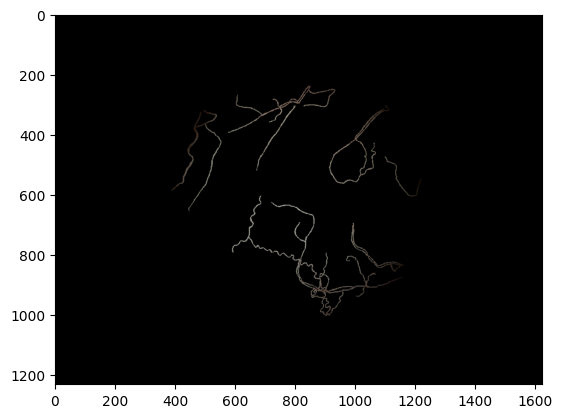

../train_dataset_mc/masks/533.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


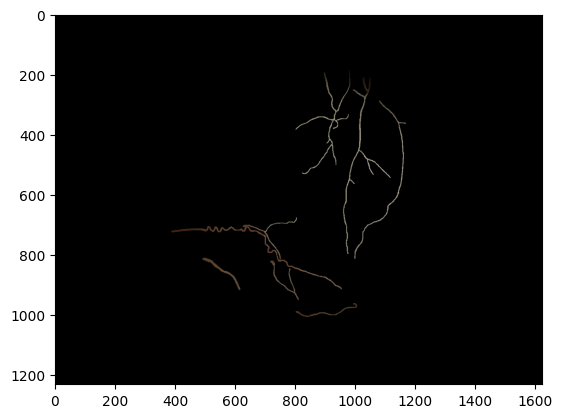

../train_dataset_mc/masks/172.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


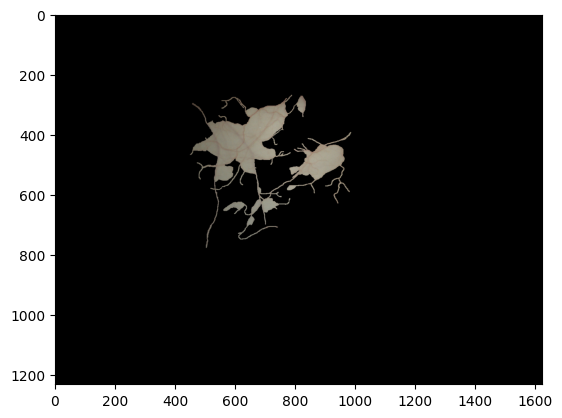

../train_dataset_mc/masks/34.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


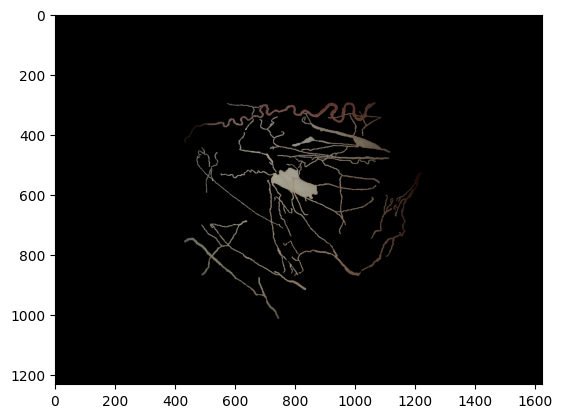

../train_dataset_mc/masks/241.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


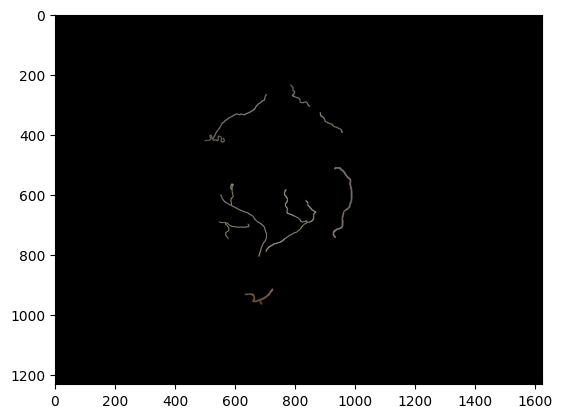

../train_dataset_mc/masks/340.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


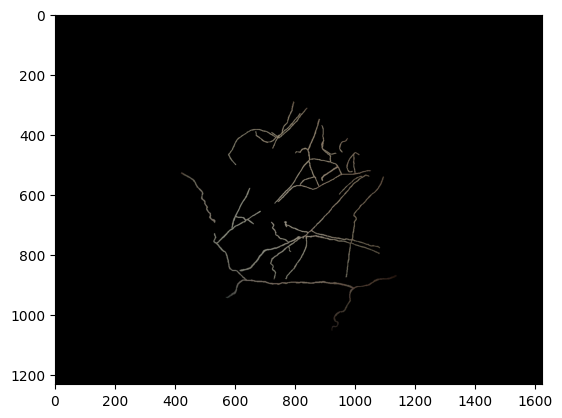

../train_dataset_mc/masks/46.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


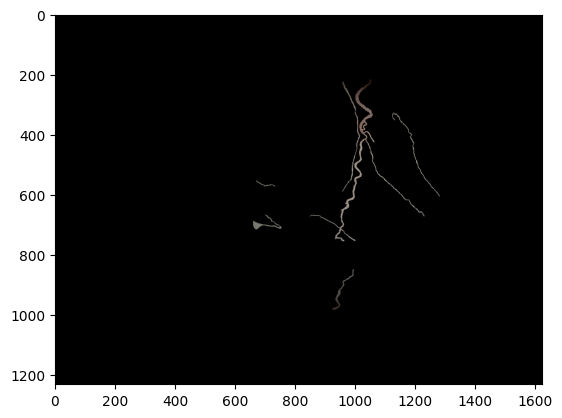

../train_dataset_mc/masks/363.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


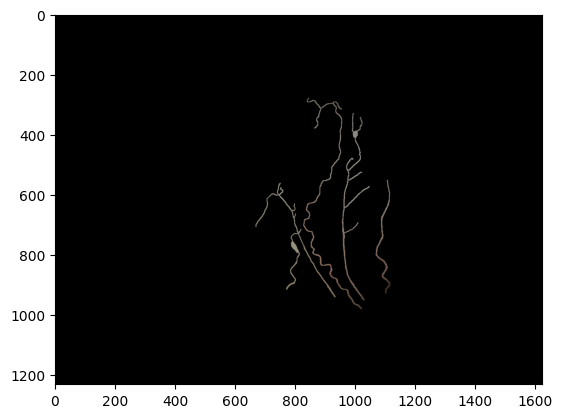

../train_dataset_mc/masks/676.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


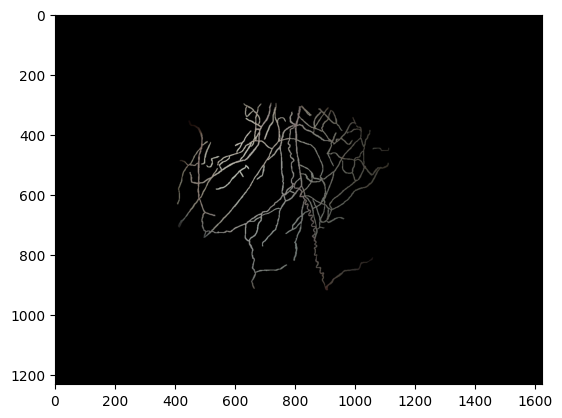

../train_dataset_mc/masks/555.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


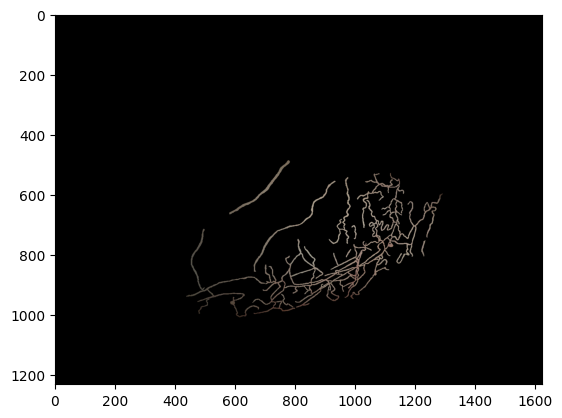

../train_dataset_mc/masks/16.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


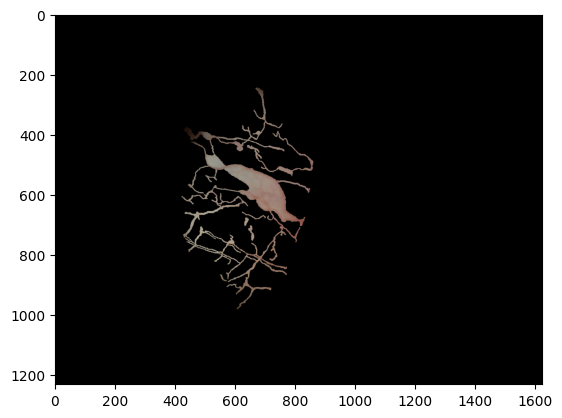

../train_dataset_mc/masks/125.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


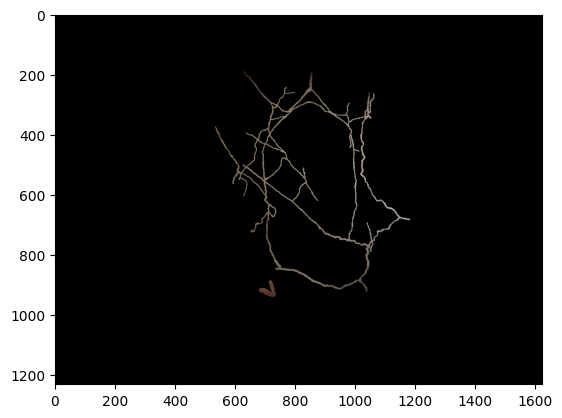

../train_dataset_mc/masks/661.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


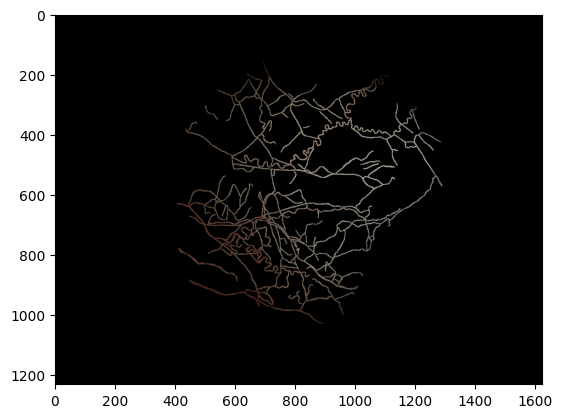

../train_dataset_mc/masks/768.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


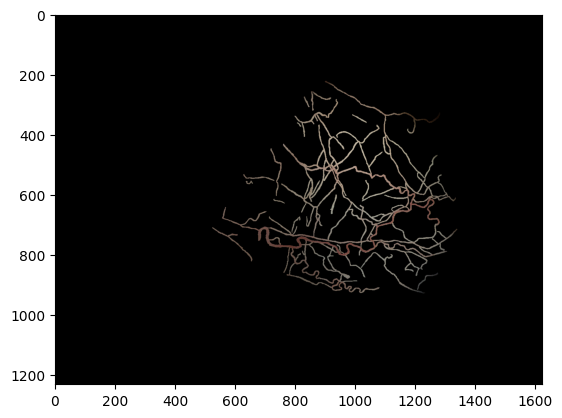

../train_dataset_mc/masks/168.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


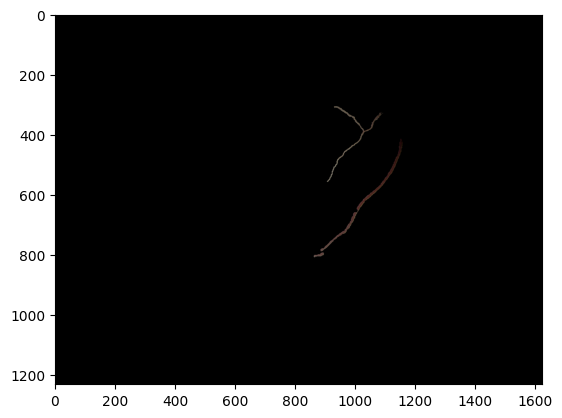

../train_dataset_mc/masks/342.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


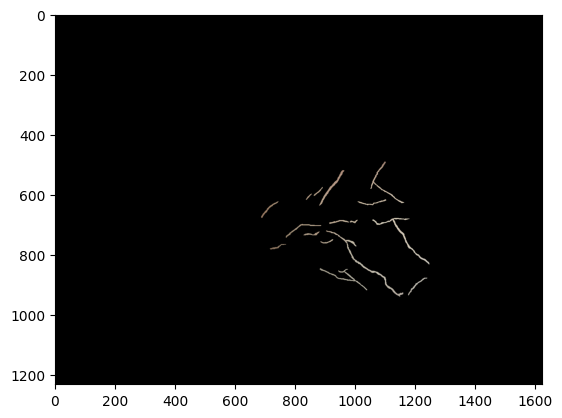

../train_dataset_mc/masks/146.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


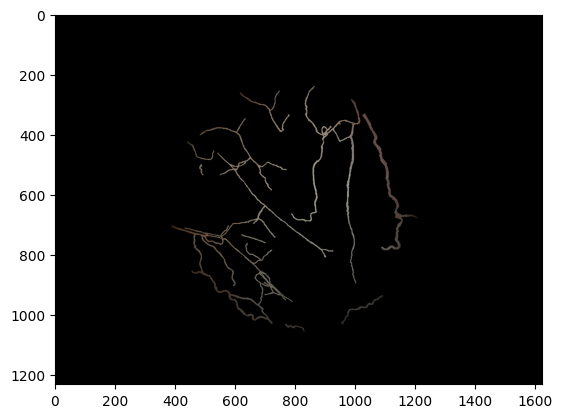

../train_dataset_mc/masks/135.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


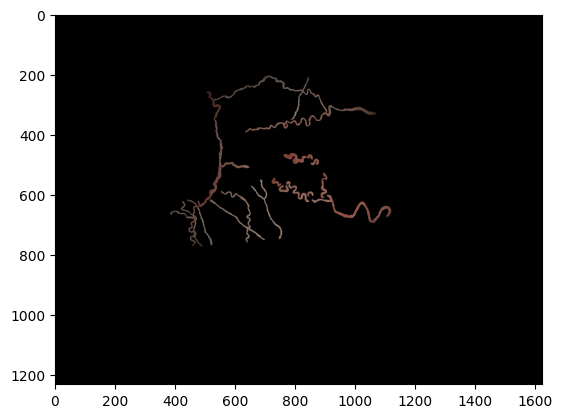

../train_dataset_mc/masks/252.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


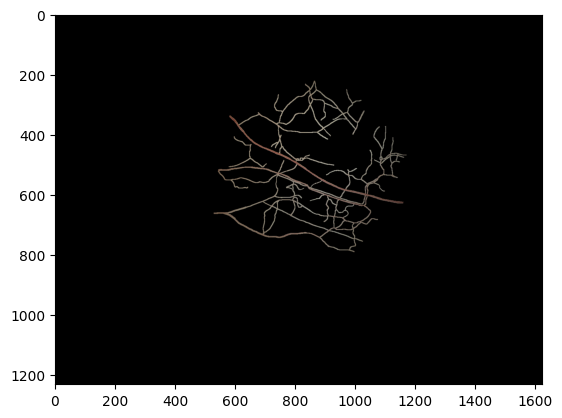

../train_dataset_mc/masks/426.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


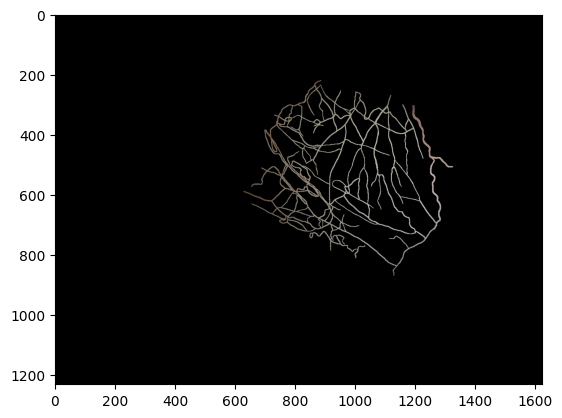

../train_dataset_mc/masks/145.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


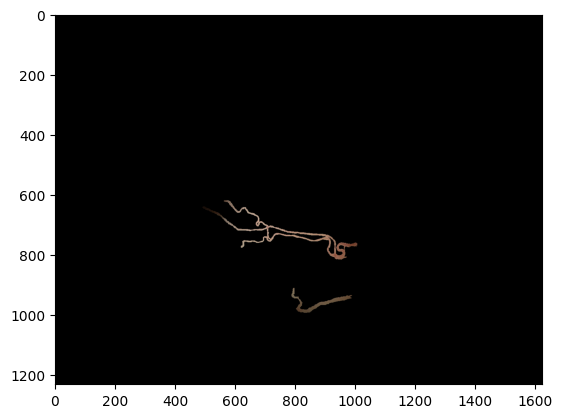

../train_dataset_mc/masks/499.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


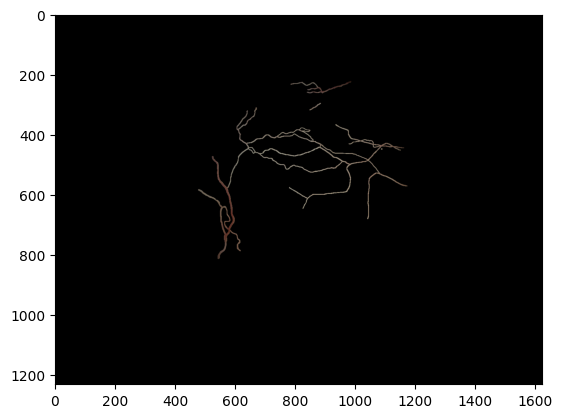

../train_dataset_mc/masks/4.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


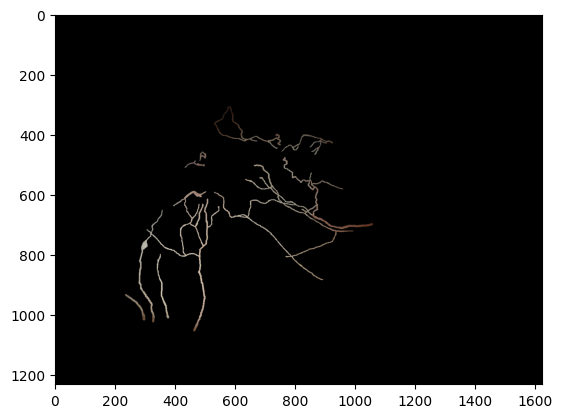

../train_dataset_mc/masks/703.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


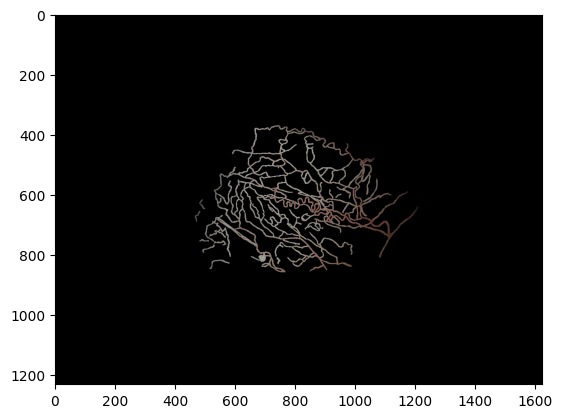

../train_dataset_mc/masks/642.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


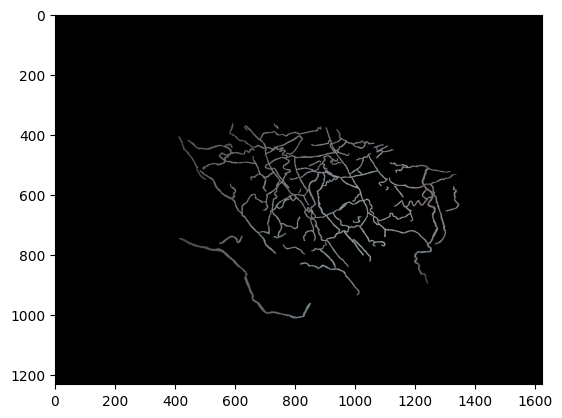

../train_dataset_mc/masks/541.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


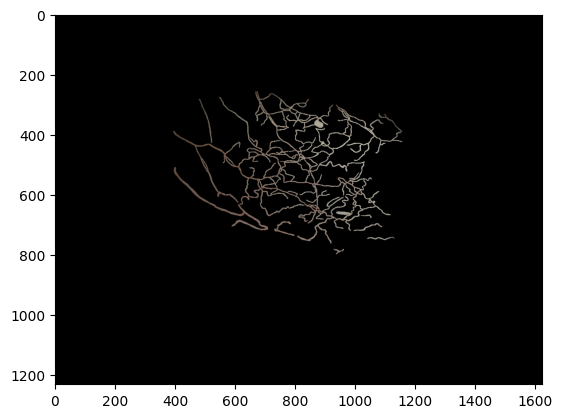

../train_dataset_mc/masks/500.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


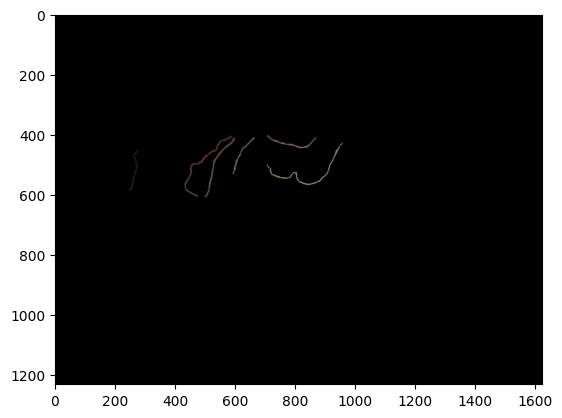

../train_dataset_mc/masks/420.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


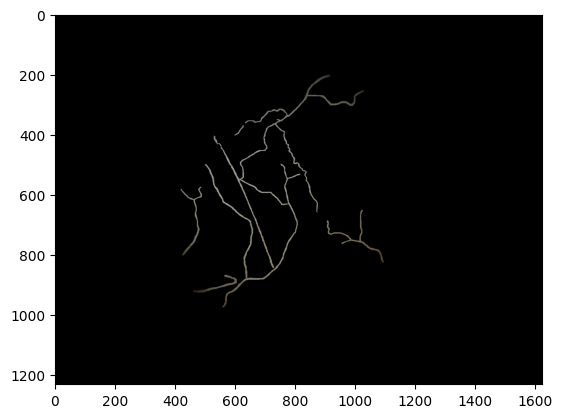

../train_dataset_mc/masks/192.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


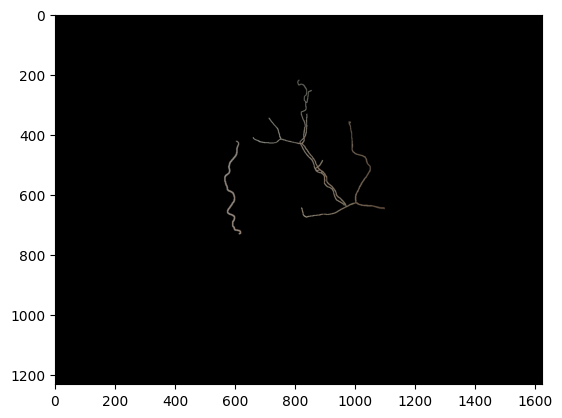

../train_dataset_mc/masks/2.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


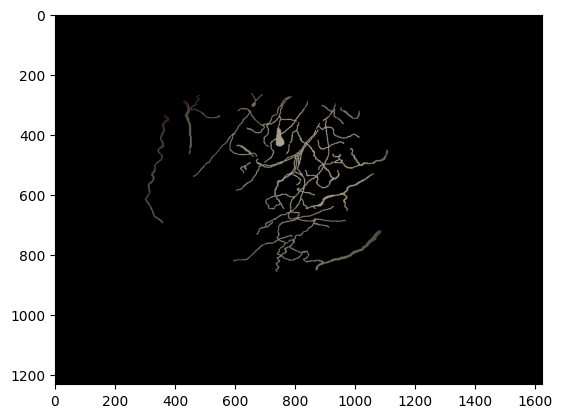

../train_dataset_mc/masks/62.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


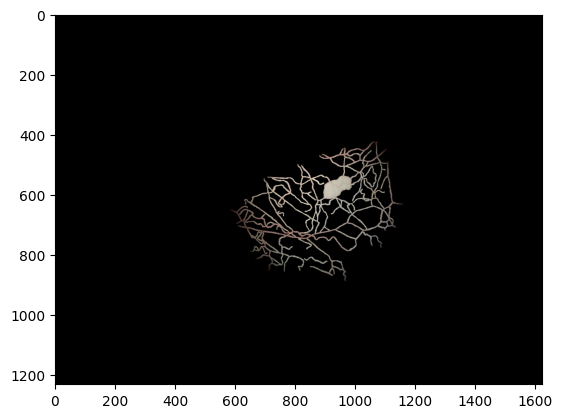

../train_dataset_mc/masks/61.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


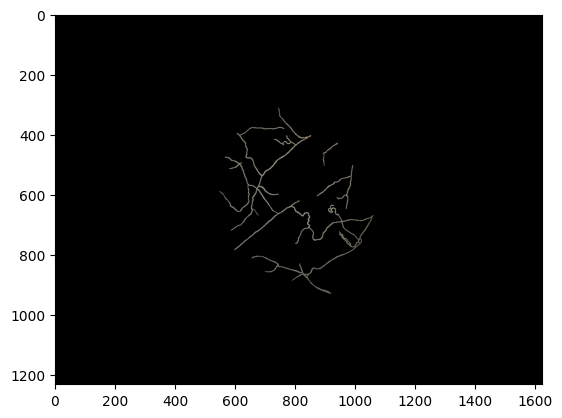

../train_dataset_mc/masks/683.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


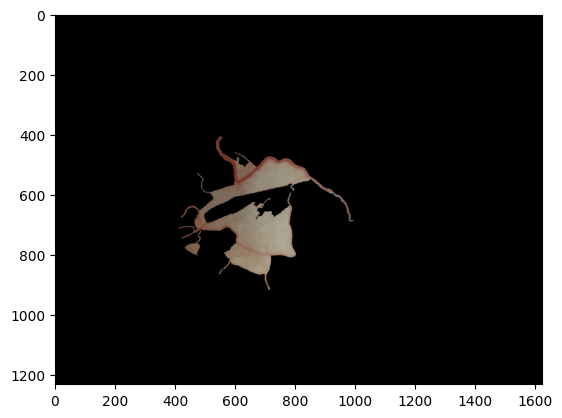

../train_dataset_mc/masks/759.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


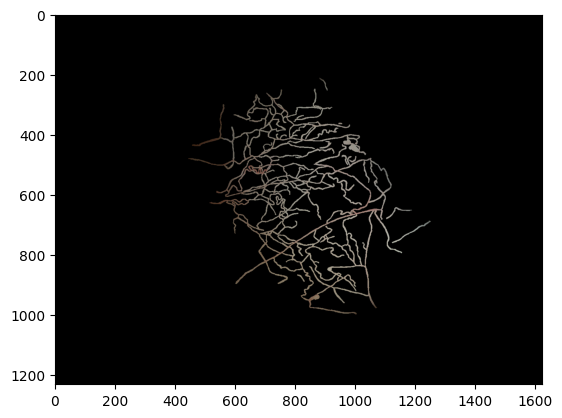

../train_dataset_mc/masks/480.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


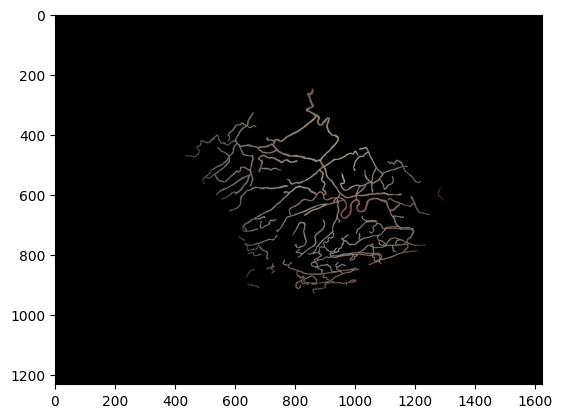

../train_dataset_mc/masks/649.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


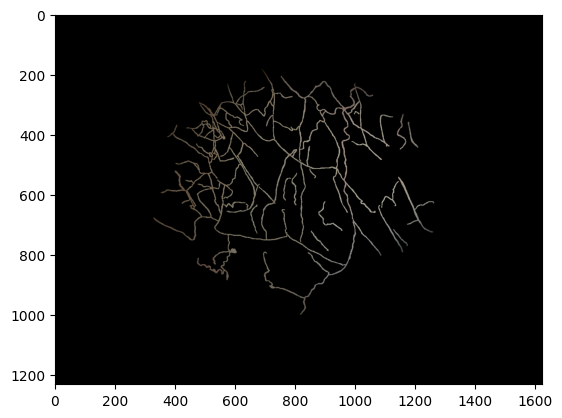

../train_dataset_mc/masks/292.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


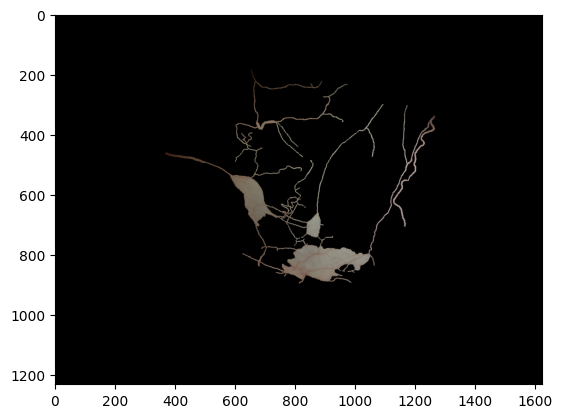

../train_dataset_mc/masks/564.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


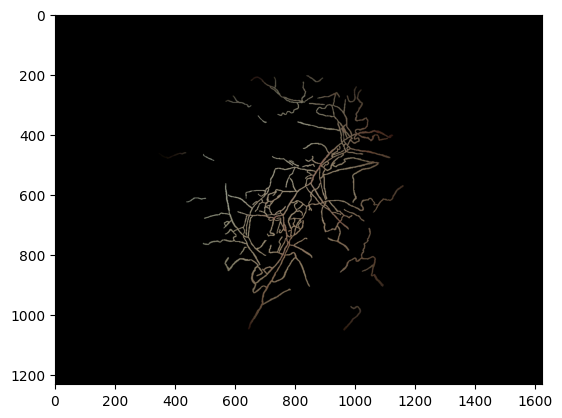

../train_dataset_mc/masks/468.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


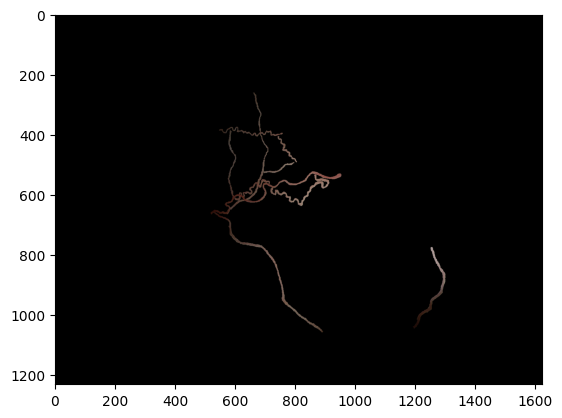

../train_dataset_mc/masks/73.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


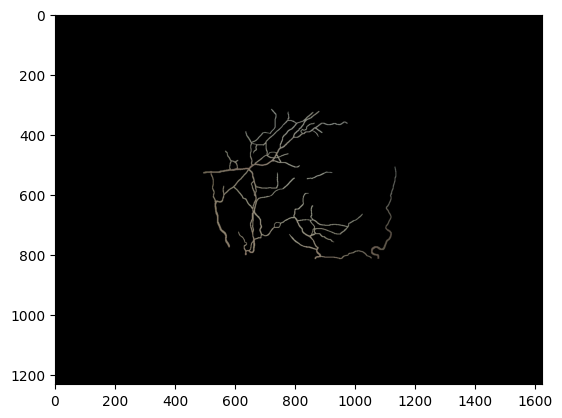

../train_dataset_mc/masks/766.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


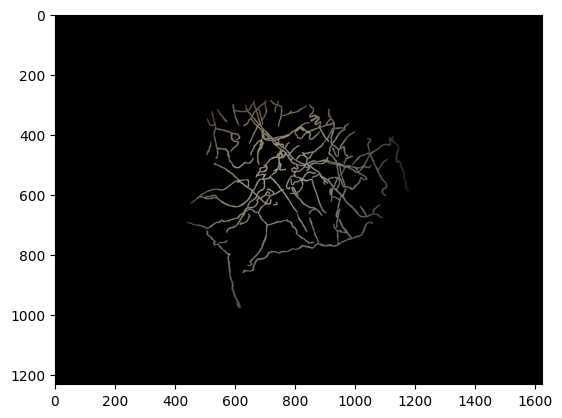

../train_dataset_mc/masks/222.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


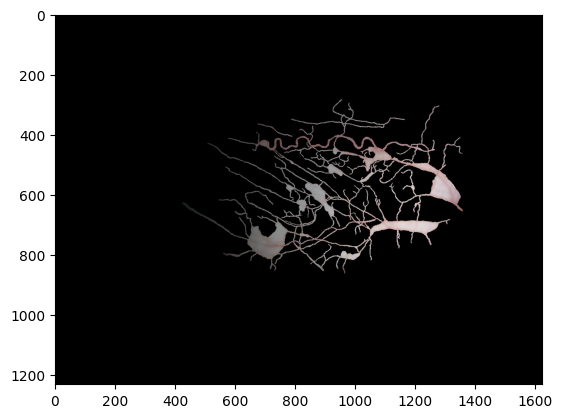

../train_dataset_mc/masks/493.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


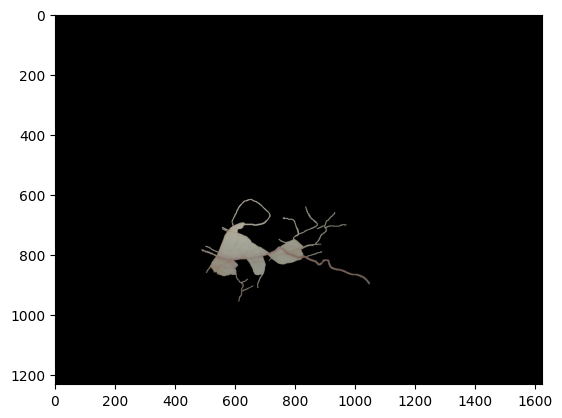

../train_dataset_mc/masks/503.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


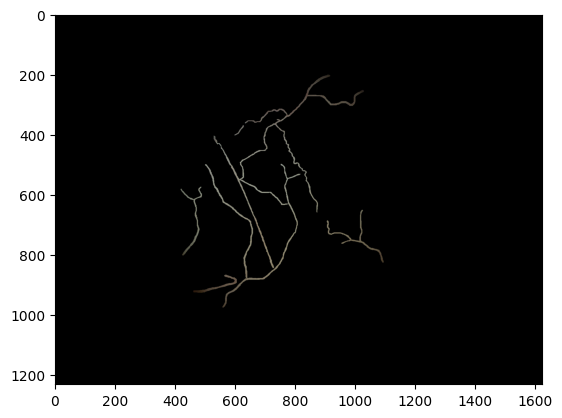

../train_dataset_mc/masks/437.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


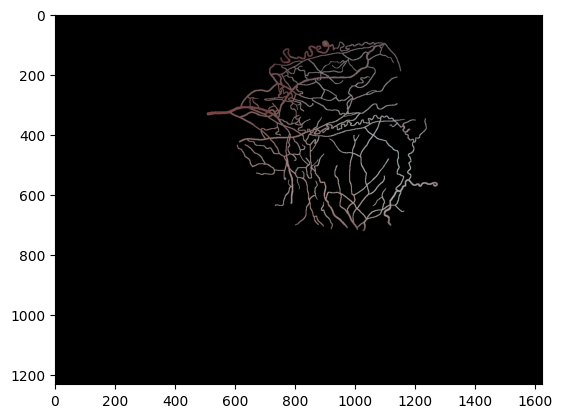

../train_dataset_mc/masks/353.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


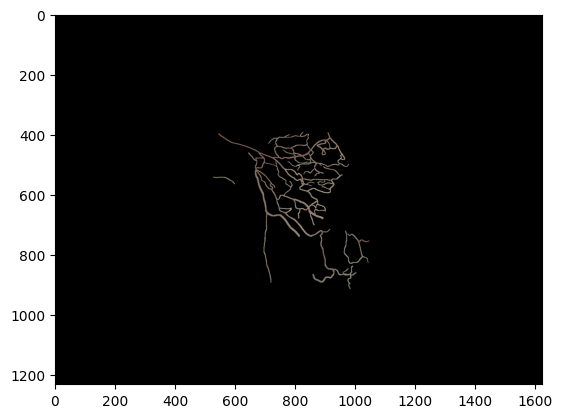

../train_dataset_mc/masks/534.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


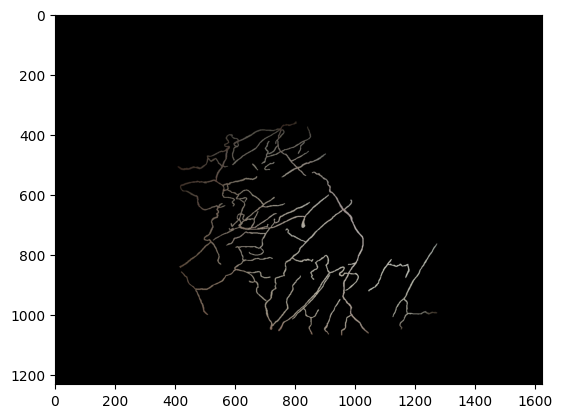

../train_dataset_mc/masks/341.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


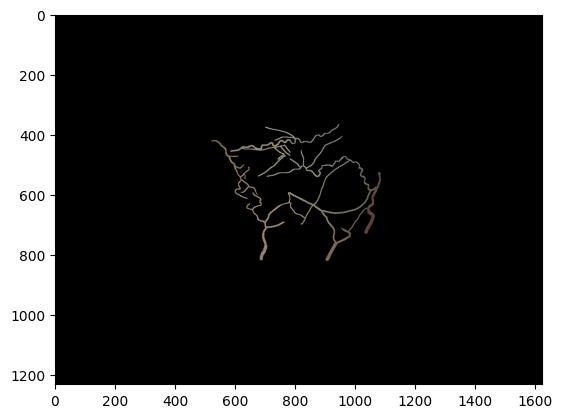

../train_dataset_mc/masks/780.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


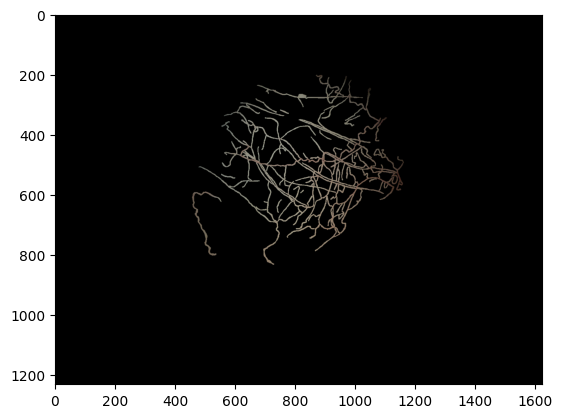

../train_dataset_mc/masks/219.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


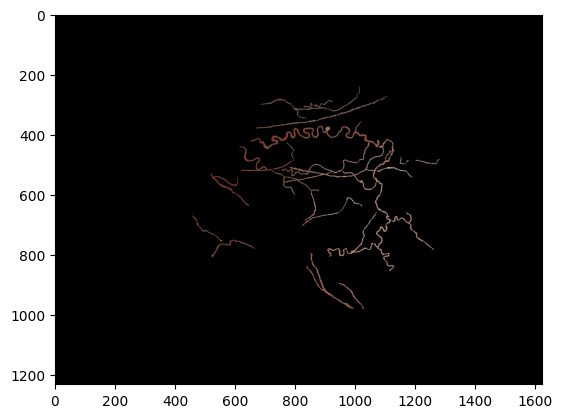

../train_dataset_mc/masks/26.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


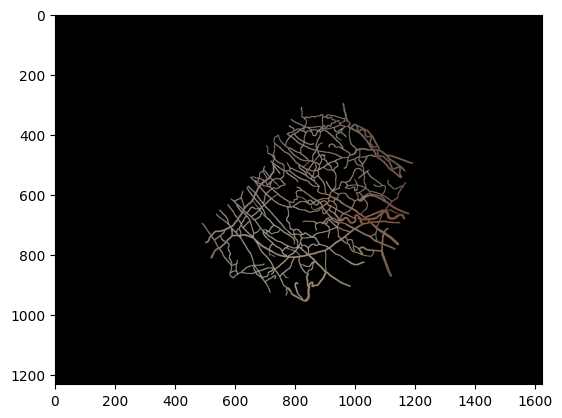

../train_dataset_mc/masks/488.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


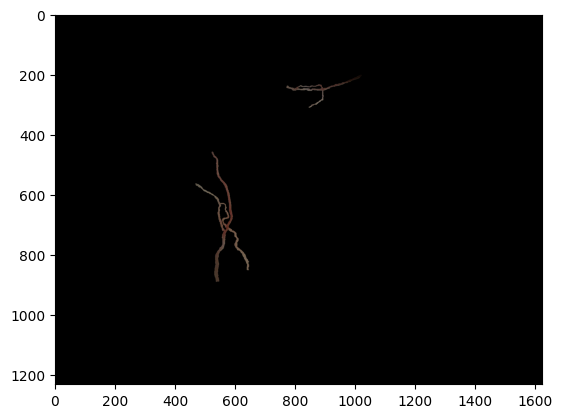

../train_dataset_mc/masks/445.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


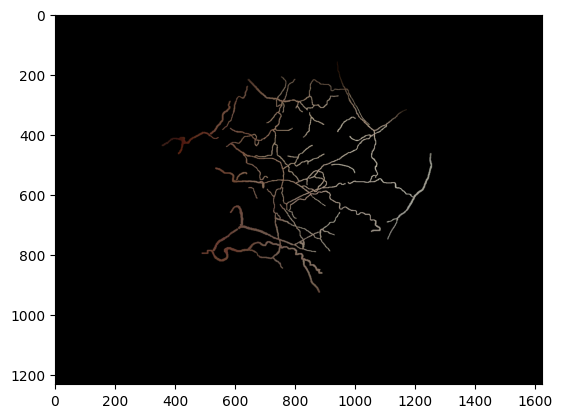

../train_dataset_mc/masks/85.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


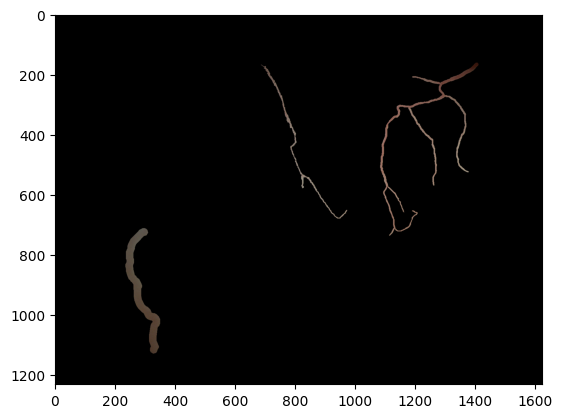

../train_dataset_mc/masks/456.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


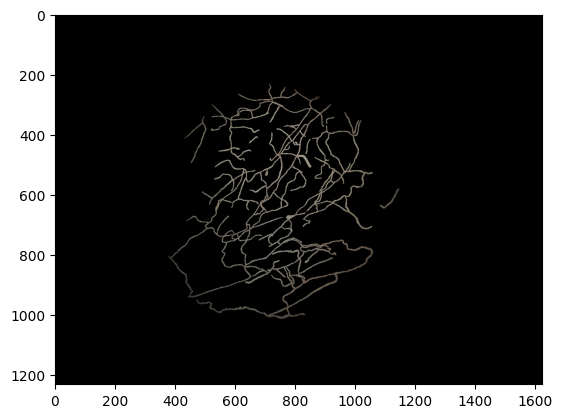

../train_dataset_mc/masks/762.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


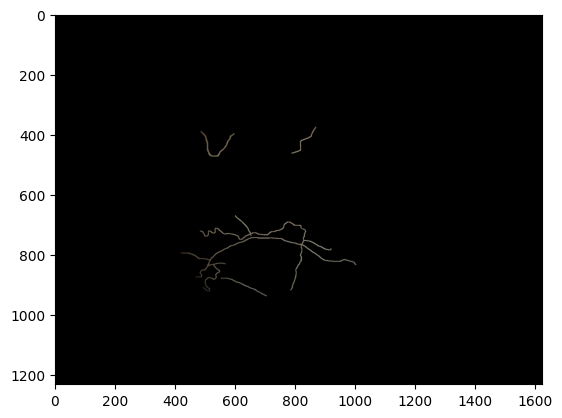

../train_dataset_mc/masks/435.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


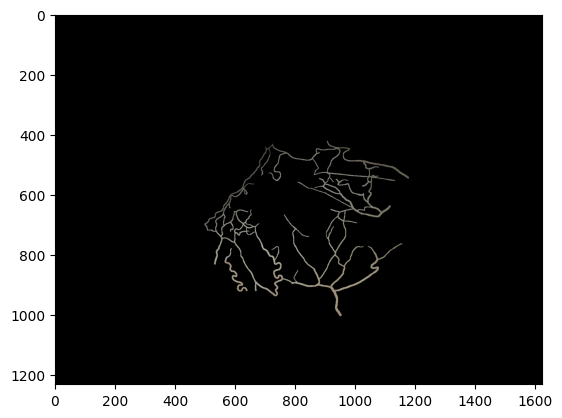

../train_dataset_mc/masks/644.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


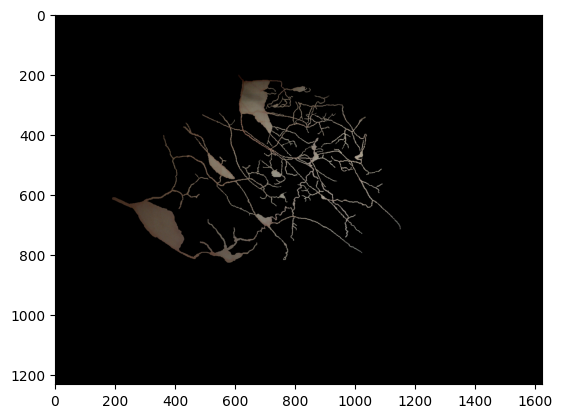

../train_dataset_mc/masks/581.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


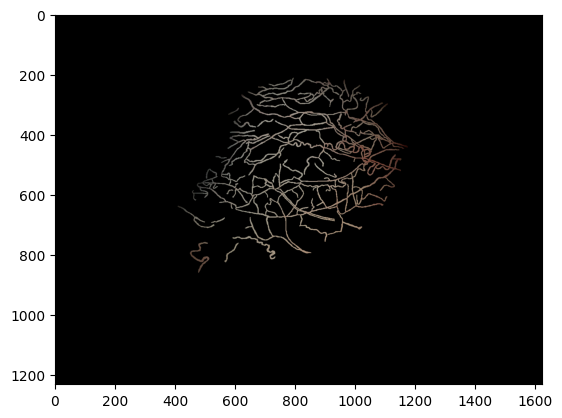

../train_dataset_mc/masks/83.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


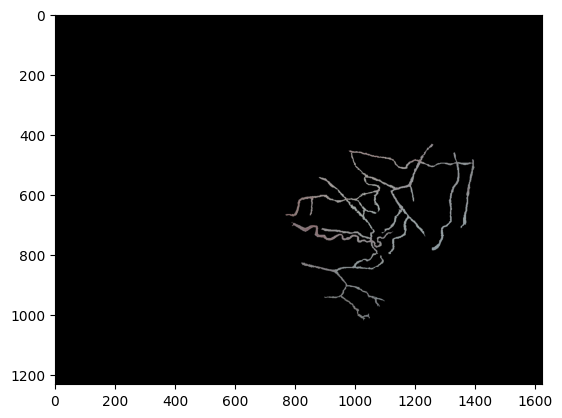

../train_dataset_mc/masks/319.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


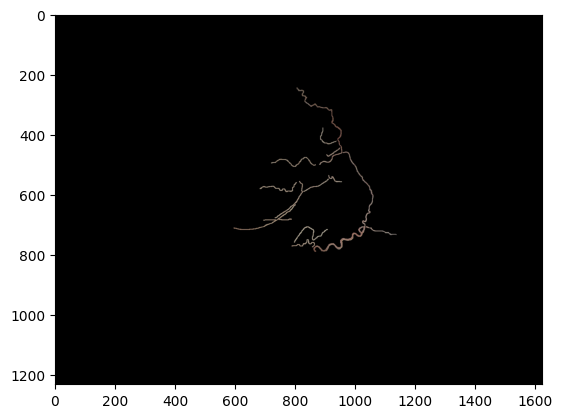

../train_dataset_mc/masks/99.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


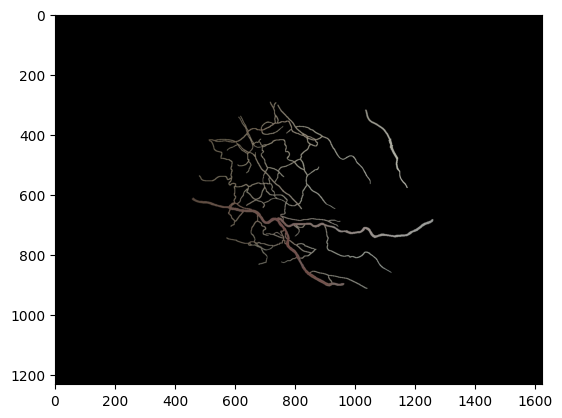

../train_dataset_mc/masks/96.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


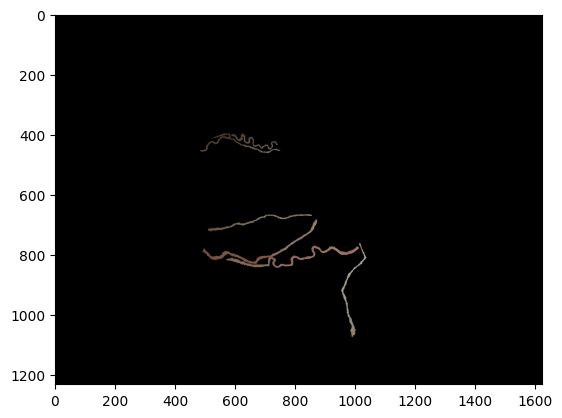

../train_dataset_mc/masks/575.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


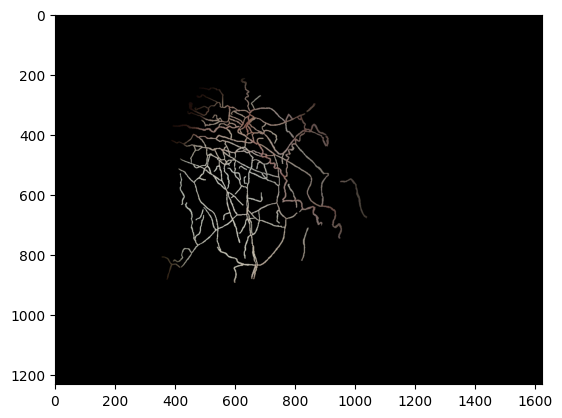

../train_dataset_mc/masks/482.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


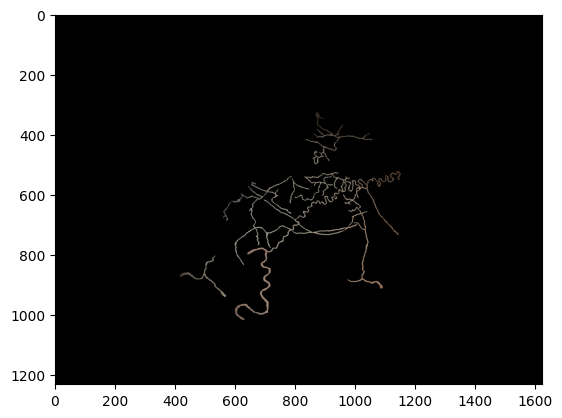

../train_dataset_mc/masks/691.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


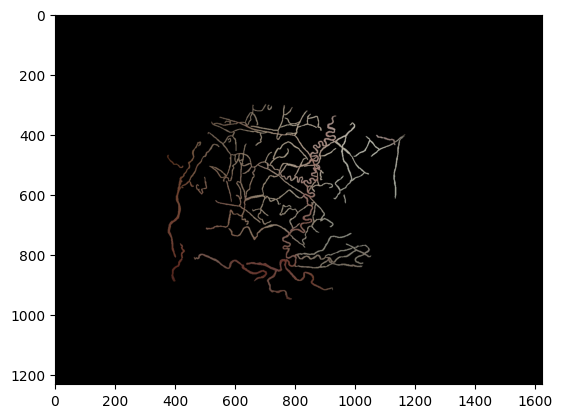

../train_dataset_mc/masks/22.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


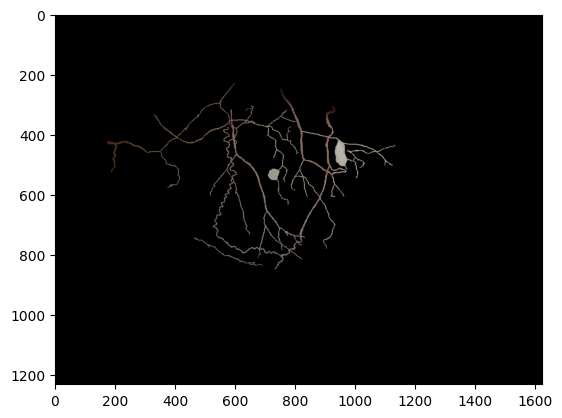

../train_dataset_mc/masks/640.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


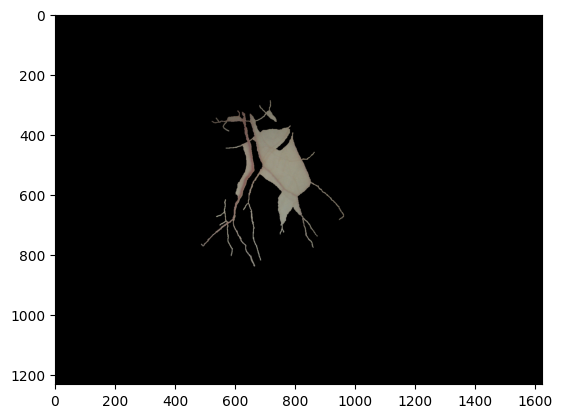

../train_dataset_mc/masks/289.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


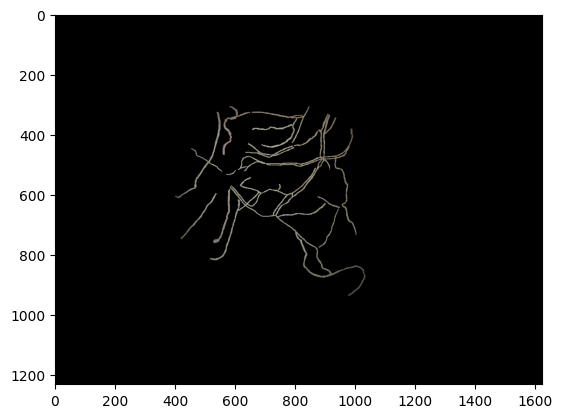

../train_dataset_mc/masks/490.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


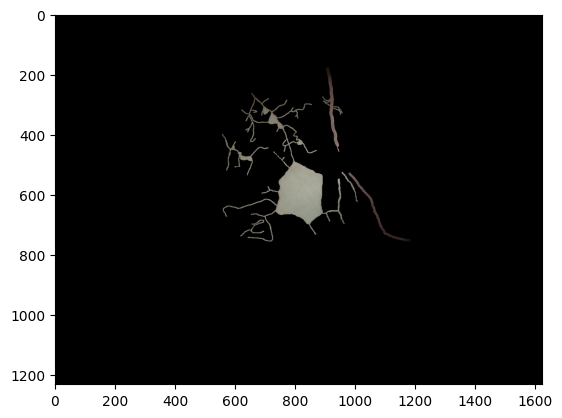

../train_dataset_mc/masks/92.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


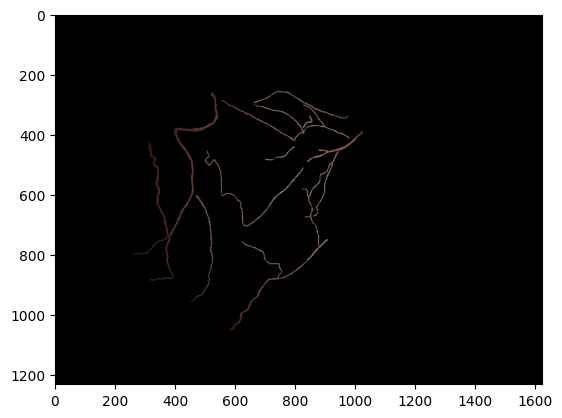

../train_dataset_mc/masks/242.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


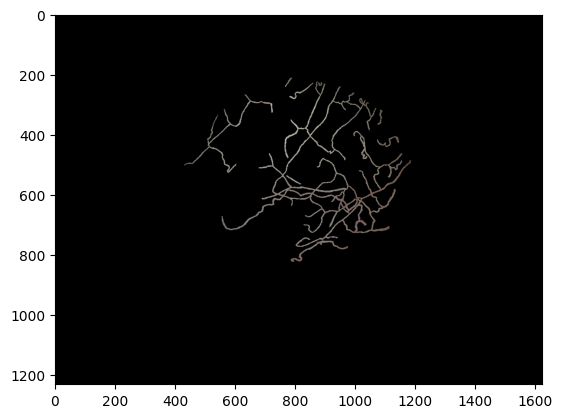

../train_dataset_mc/masks/525.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


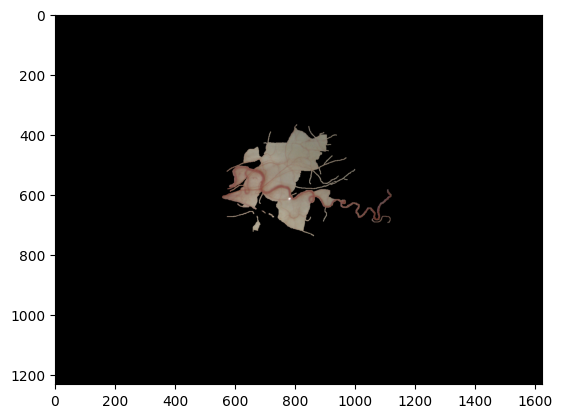

../train_dataset_mc/masks/246.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


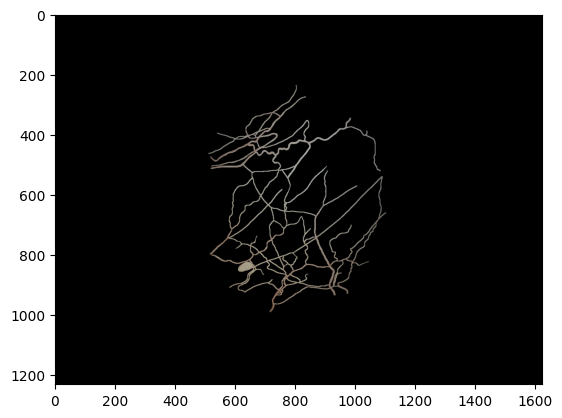

../train_dataset_mc/masks/725.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


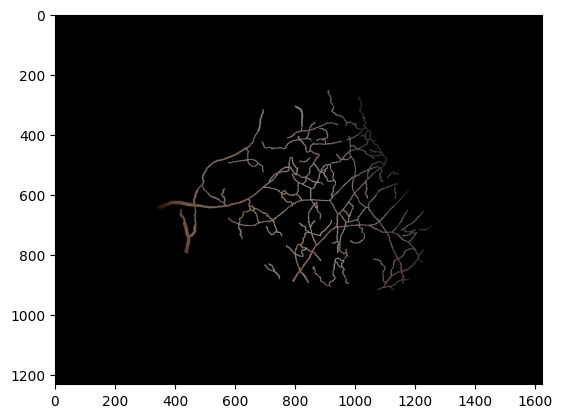

../train_dataset_mc/masks/709.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


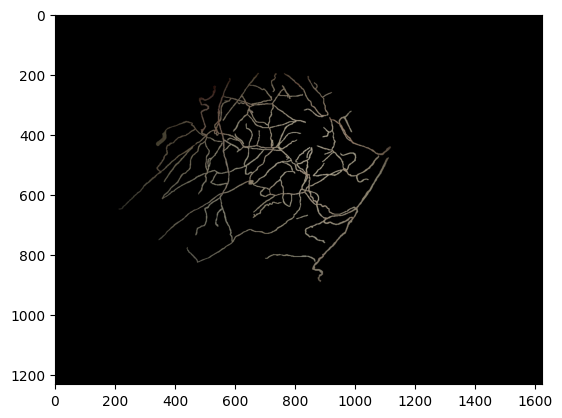

../train_dataset_mc/masks/143.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


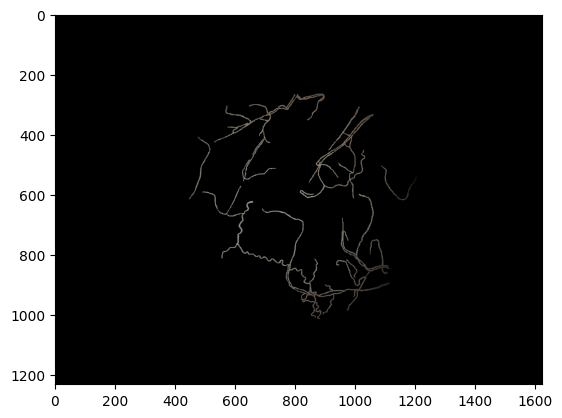

../train_dataset_mc/masks/753.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


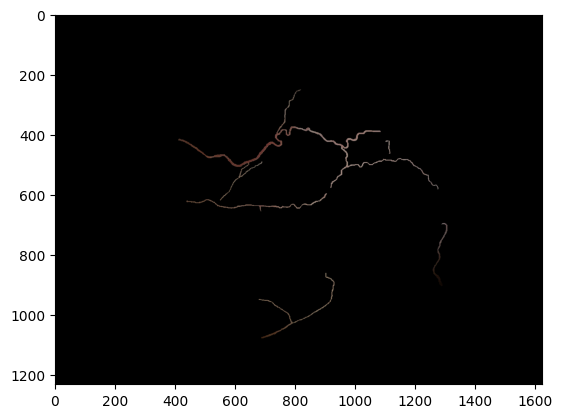

../train_dataset_mc/masks/57.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


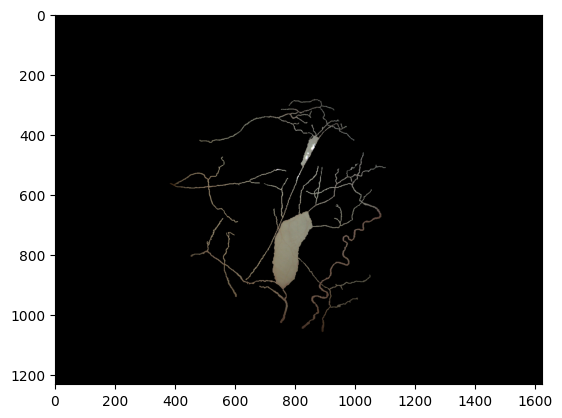

../train_dataset_mc/masks/181.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


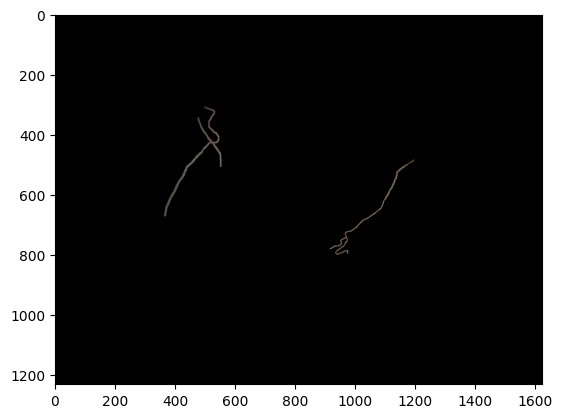

../train_dataset_mc/masks/15.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


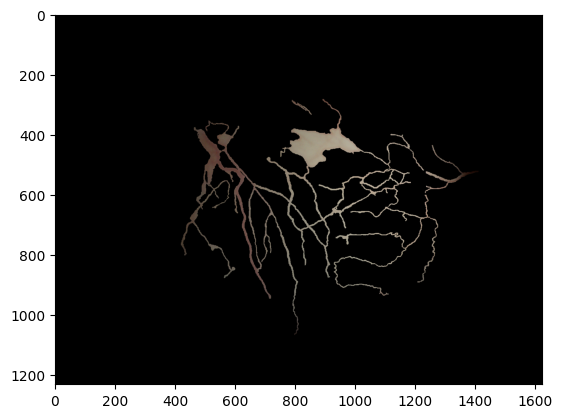

../train_dataset_mc/masks/13.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


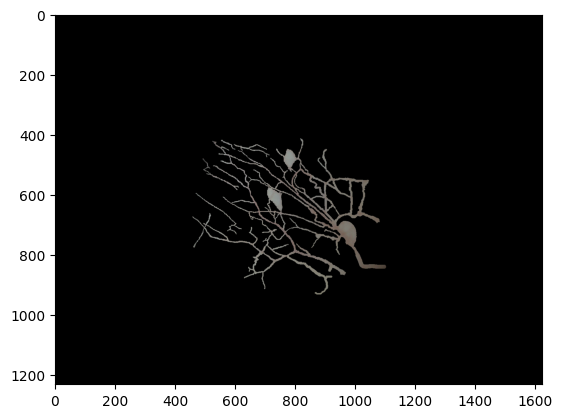

../train_dataset_mc/masks/205.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


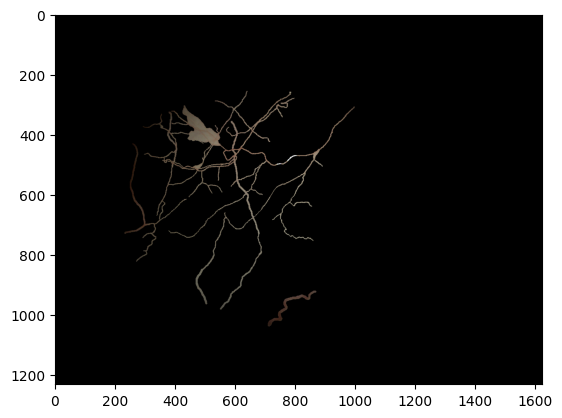

../train_dataset_mc/masks/107.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


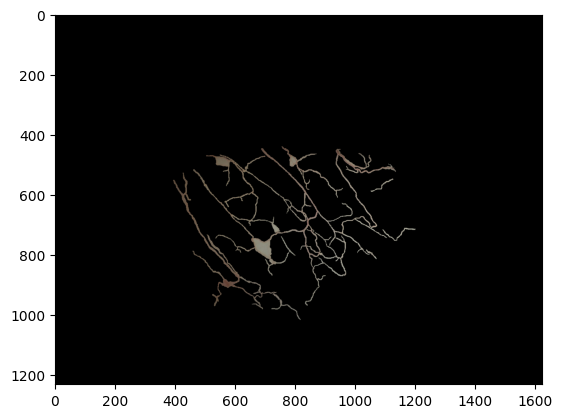

../train_dataset_mc/masks/773.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


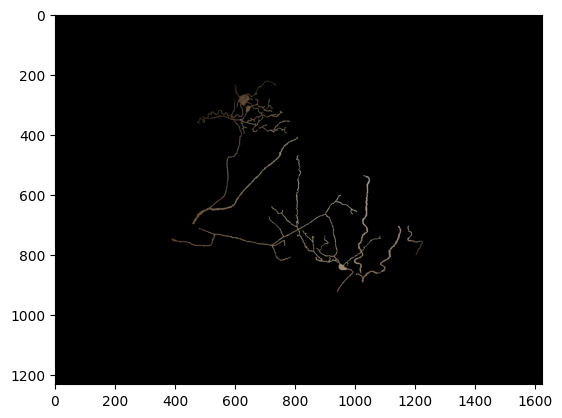

../train_dataset_mc/masks/220.npy {0.0, 1.0, 2.0, 3.0}
(1232, 1624, 3)
(1232, 1624, 3)


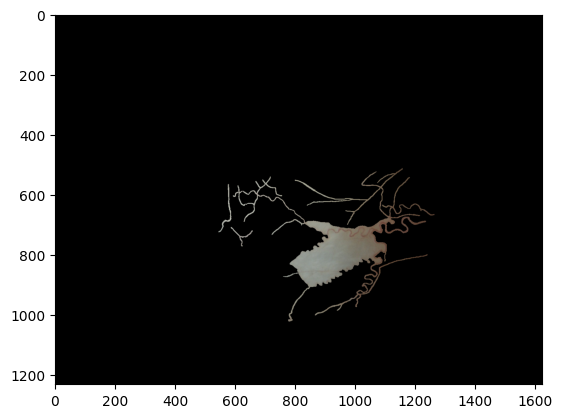

../train_dataset_mc/masks/554.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


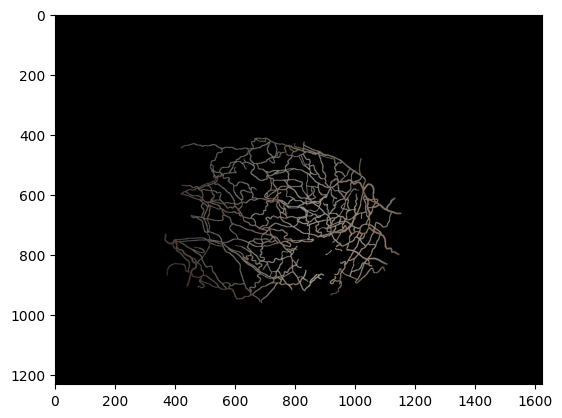

../train_dataset_mc/masks/429.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


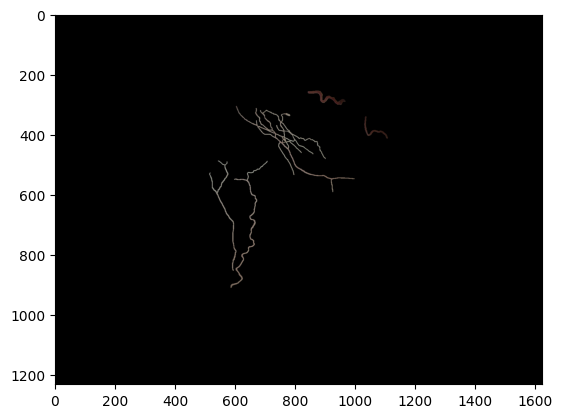

../train_dataset_mc/masks/373.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


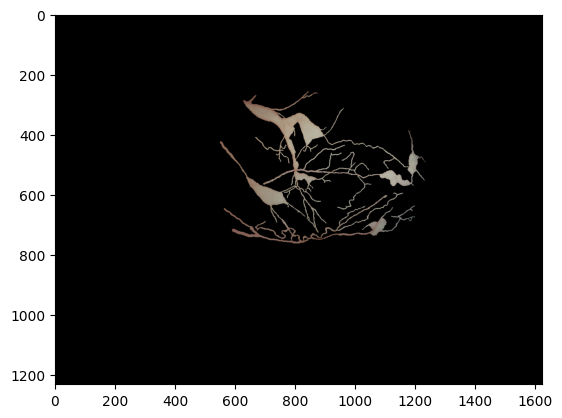

../train_dataset_mc/masks/376.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


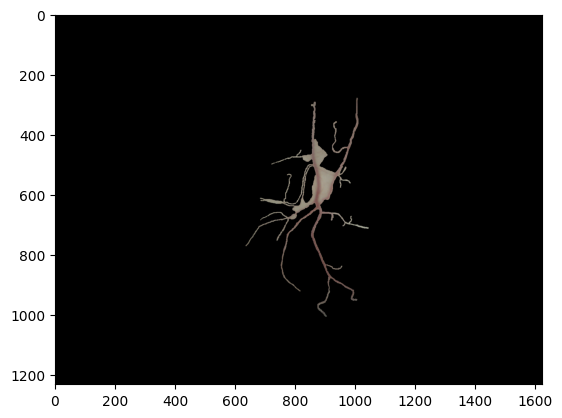

../train_dataset_mc/masks/573.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


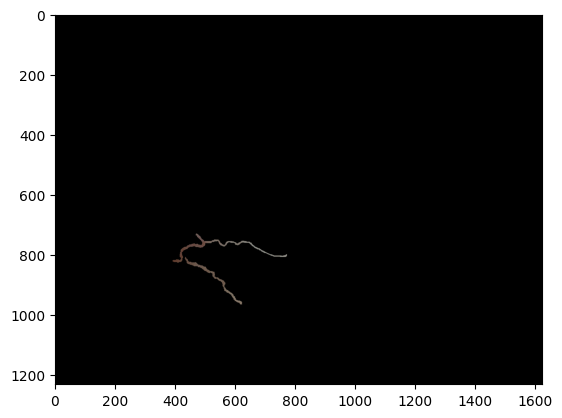

../train_dataset_mc/masks/115.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)
(1232, 1624, 3)


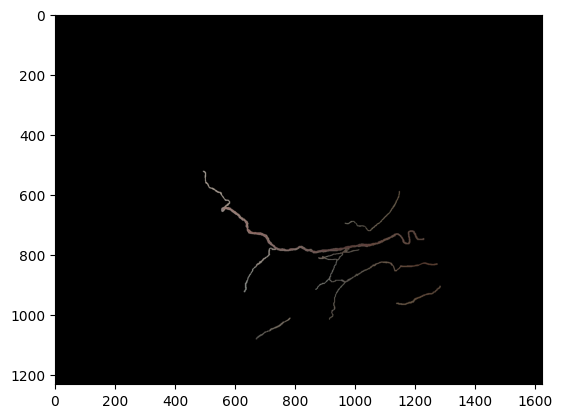

../train_dataset_mc/masks/206.npy {0.0, 1.0, 2.0}
(1232, 1624, 3)


ValueError: operands could not be broadcast together with shapes (1232,1624,3) (947,1248,3) () 

In [52]:
for i in masks:
    mask = np.load(i)
    name = i.split("/")[-1].split(".")[0]
    if len(set(mask.reshape(-1))) > 2:
        
        print(i, set(mask.reshape(-1)))
        im = read_image(os.path.join(images, name + ".png"))
        m = np.concatenate([mask, mask, mask], axis=-1)
        print(m.shape)
        res = np.where(m > 0, im, 0)
        print(res.shape)
        plt.imshow(res)
        plt.show()
        #plt.imshow(mask)
        #plt.show()
        

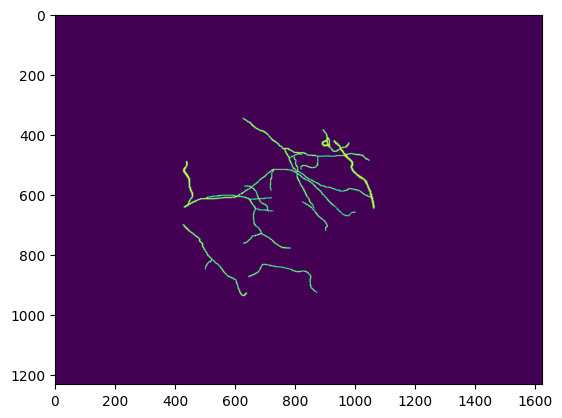

In [26]:
plt.imshow(mask*255)

In [18]:
mask.shape

(1232, 1624, 1)

In [17]:
set(mask.reshape(-1))

{0.0, 1.0}

In [53]:
def parse_polygon(coordinates: dict, image_size: tuple) -> np.ndarray:
    mask = np.zeros(image_size, dtype=np.float32)
    if len(coordinates) == 1:
        points = [np.int32(coordinates)]
        cv2.fillPoly(mask, points, 1)
    else:
        for polygon in coordinates:
            points = [np.int32([polygon])]
            cv2.fillPoly(mask, points, 1)
    return mask

def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:

    mask = np.zeros(image_size, dtype=np.float32)
    coordinates = shape['coordinates']
    if shape['type'] == 'MultiPolygon':
        for polygon in coordinates:
            mask += parse_polygon(polygon, image_size)
    else:
        mask += parse_polygon(coordinates, image_size)
    
    return mask

In [54]:
def read_layout(path: str, image_size: tuple) -> np.ndarray:
    class_ids = {"vessel": 1}
    with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
        json_contents = json.load(f)

    num_channels = 2
        
    mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
    mask = np.zeros(image_size, dtype=np.float32)

    if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
        features = json_contents['features']
    elif type(json_contents) == list:
        features = json_contents
    else:
        features = [json_contents]

    for shape in features:
        channel_id = class_ids["vessel"]
        mask = parse_mask(shape['geometry'], image_size)
        mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

    mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)
    
    return 1 -np.expand_dims(mask_channels[0], axis=-1)
    #return np.stack(mask_channels[:,:,0], axis=-1)